- 어벤저스:엔드게임의 리뷰데이터를 수직하여 Word2Vec 모델을 만들고 특정 단어를 입력하여 유사 단어를 나열

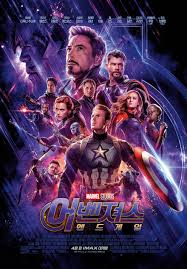

# 데이터크롤링

In [3]:
import requests
from bs4 import BeautifulSoup
import re
import pandas as pd
import time
from tqdm import trange, notebook

pre = "https://movie.naver.com/movie/bi/mi/pointWriteFormList.nhn?code=136900&type=after&isActualPointWriteExecute=false&isMileageSubscriptionAlready=false&isMileageSubscriptionReject=false&page="

review = []
rate = []

cnt = 0


    
# for i in range(1,4890, 5): # 약 만개의 데이터

for i in notebook.tqdm(range(1,4980,5)):
    time.sleep(0.1)  # IP가 차단되지 않도록 time.sleep을 통해 쉬어주도록 함
    url = pre + str(i)
    res = requests.get(url)
    soup = BeautifulSoup(res.content,'html.parser')
    
    id_list = []
    id_pre = "_filtered_ment_"

    for i in range(10):
        id_list.append(id_pre+str(i))

    for id in id_list:
        review.append(soup.find("span", {"id":id}).get_text().strip())

        rate_list = []
        rate_list = (soup.select("div.star_score > em"))
    
    for r in rate_list:
        r = int(re.sub('<.+?>','',str(r)))
        rate.append(r)
        
df = pd.DataFrame({"review" : review, "rate" : rate})

In [4]:
df

,review,rate
0,마블 3000만큼 사랑합니다,10
1,Avengers Assemble!,10
2,I'm Ironman.,10
3,아이언맨으로 시작해서 아이언맨으로 끝난다..,10
4,아스가디언즈 오브 갤럭시 벌써부터 기대됨 ㅋㅋㅋㅋ,10
...,...,...
9955,최고의 마무리!! 행복했습니다,10
9956,너무 재미있었고 한편으로는 마지막이라 아쉬웠습니다.,10
9957,스포는 자제....진짜 완벽한 마무리ㅠㅠ,10
9958,슬프지만 잘 마무리 한 것 같다,10


In [5]:
df.to_csv('review.csv') # csv파일로 저장

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import urllib.request
from gensim.models.word2vec import Word2Vec
from konlpy.tag import Okt
import numpy as np

train_data = pd.read_csv("review.csv")
train_data[:5] # 상위 5개 출력

,Unnamed: 0,review,rate
0,0,마블 3000만큼 사랑합니다,10
1,1,Avengers Assemble!,10
2,2,I'm Ironman.,10
3,3,아이언맨으로 시작해서 아이언맨으로 끝난다..,10
4,4,아스가디언즈 오브 갤럭시 벌써부터 기대됨 ㅋㅋㅋㅋ,10


### 현재 리뷰 분석에서 사용할 형태소 분석기는 konlpy이기 때문에 한글이 아닌 리뷰는 제거시킴

In [2]:
train_data['review'] = train_data['review'].str.replace("[^ㄱ-하-ㅣ가-힣]","") # 한글이 아니면 전부 제거
train_data[:5] # 상위 5개 출력

,Unnamed: 0,review,rate
0,0,마블만큼사랑합니다,10
1,1,,10
2,2,,10
3,3,아이언맨으로시작해서아이언맨으로끝난다,10
4,4,아스가디언즈오브갤럭시벌써부터기대됨ㅋㅋㅋㅋ,10


In [3]:
train_data['review'] = train_data['review'].str.replace("ㅋ+","") # ㅋㅋㅋ등의 문자 제거
train_data['review'] = train_data['review'].str.replace("ㅜ+","") # ㅠㅠㅠ등의 문자 제거
train_data['review'] = train_data['review'].str.replace("ㅠ+","") # ㅜㅜㅜ등의 문자 제거
train_data[:5]

,Unnamed: 0,review,rate
0,0,마블만큼사랑합니다,10
1,1,,10
2,2,,10
3,3,아이언맨으로시작해서아이언맨으로끝난다,10
4,4,아스가디언즈오브갤럭시벌써부터기대됨,10


In [4]:
train_data.replace("",np.nan, inplace=True) # 정규식을 통해 공백으로 치환된 데이터를 nan값으로 치환

# 결측치 확인 및 제거

In [5]:
train_data.isnull().sum()

Unnamed: 0      0
review        325
rate            0
dtype: int64

In [6]:
train_data = train_data.dropna(how='any') # Null값이 존재하는 행 제거
print(train_data.isnull().values.any())  # Null값이 존재하는지 확인

False


In [7]:
train_data.head()

,Unnamed: 0,review,rate
0,0,마블만큼사랑합니다,10
3,3,아이언맨으로시작해서아이언맨으로끝난다,10
4,4,아스가디언즈오브갤럭시벌써부터기대됨,10
5,5,히어로물보고울줄누가알겠습니까,10
6,6,인피니티워가년을무너뜨리는영화라면엔드게임은년을돌아보는영화입니다,10


In [8]:
from tqdm import trange, notebook

# 불용어 지정
stopwords = ['의','가','이','은','들','는','좀','잘','걍','과','도','를','으로','자','에','와','한','하다']

# 형태소 분석기 OKT를 사용한 토큰화 작업 (다소 시간 소요)
okt = Okt()
tokenized_data = []

#for sentence in train_data['review']:

for sentence in notebook.tqdm(train_data['review']):  # 프로그레스 바
    temp_X = okt.morphs(sentence, stem=True) # 토큰화
    temp_X = [word for word in temp_X if not word in stopwords] # 불용어 제거
    temp_X = [word for word in temp_X if len(word) > 1] # 한글자는 제거
    tokenized_data.append(temp_X)


In [9]:
tokenized_data

[['마블', '만큼', '사랑'],
 ['아이언맨', '시작', '아이언맨', '끝나다'],
 ['아스', '가디언즈', '오브', '갤럭시', '벌써', '부터', '기대', '되다'],
 ['히어로', '보다', '누가', '알다'],
 ['인피니티', '가년', '무너', '뜨다', '영화', '라면', '엔드게임', '돌아보다', '영화', '이다'],
 ['쥐다', '살리다'],
 ['마지막', '에서', '싸다'],
 ['점안', '주다', '사람', '마블', '에서까지', '밖에', '애정', '없다'],
 ['아이언맨', '아이언맨', '끝나다', '대장정'],
 ['마블', '시대', '해주다', '감사하다'],
 ['다음', '아이언맨', '아이언맨', '에나', '꼬마', '구나'],
 ['아이언맨', '부터', '사람', '알다', '이영화', '그동안', '모든', '보상', '받다', '영화', '는걸'],
 ['감히', '가평', '가하다', '수준', '영화', '아니다', '다점', '부족하다', '별점', '만큼', '준비', '해주다'],
 ['들쥐', '양자역학', '기계', '버튼', '누르다', '확률', '세상', '살리다', '확률', '크다'],
 ['엔드게임', '이라는', '부제', '누가', '붙다', '늘다', '모르다', '진짜', '완벽하다'],
 ['여자', '틀어막다', '보더', '물론', '나다', '막다'],
 ['쿠키', '없다', '기다리다', '말다'],
 ['어벤져스', '셈블'],
 ['재밌다', '진짜', '재밌다', '개인', '인피니티', '가다', '소름', '돋다'],
 ['시간', '안양', '터널', '있다', '기분'],
 ['아이언맨', '부터', '보다', '사람', '눈물', '나오다'],
 ['보다', '마블', '아니다', '도표', '은합'],
 ['하워드', '포츠', '도분', '좋다', '아버지', '되어다'],
 ['진짜', '소름', '돋다', '역대

리뷰의 최대 길이 : 40
리뷰의 평균 길이 : 6.060404774260508


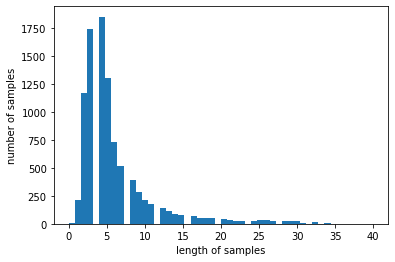

In [10]:
# 리뷰 길이 분포 확인
print("리뷰의 최대 길이 :",max(len(I) for I in tokenized_data))
print("리뷰의 평균 길이 :",sum(map(len, tokenized_data))/len(tokenized_data))

plt.hist([len(s) for s in tokenized_data], bins=50)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

In [11]:
from gensim.models import Word2Vec

model = Word2Vec(sentences = tokenized_data, size = 100, window = 5, min_count = 5, workers = 4, sg = 0)
# 완성된 임베딩 매트릭스의 크기 확인
model.wv.vectors.shape

(1300, 100)

# 특정단어 입력 유사도 확인

In [12]:
print(model.wv.most_similar("토니스타크"))
similar_word = model.wv.most_similar("토니스타크")

[('토니', 0.9998288750648499), ('캡틴', 0.9998272657394409), ('되어다', 0.9998269081115723), ('노스', 0.9998254179954529), ('우리', 0.9998224973678589), ('추억', 0.9998204708099365), ('이영화', 0.9998194575309753), ('모두', 0.9998161792755127), ('영웅', 0.9998139142990112), ('토르', 0.9998118877410889)]


In [13]:
similar_word_df = pd.DataFrame(similar_word)
similar_word_df.columns=["유사단어","유사도"]
similar_word_df

,유사단어,유사도
0,토니,0.999829
1,캡틴,0.999827
2,되어다,0.999827
3,노스,0.999825
4,우리,0.999822
5,추억,0.999820
6,이영화,0.999819
7,모두,0.999816
8,영웅,0.999814
9,토르,0.999812


# 시각화

In [37]:
from gensim.models import Word2Vec

# 형태소 분석 완료
sentences = tokenized_data[:15] # 가시성으 위해 tokenized_data에서 10개의 데이터만 인덱싱하여 사용

# 문장을 이용하여 단어와 벡터를 생성한다.
model = Word2Vec(sentences, size=300, window=3, min_count=1, workers=1)

# 단어 벡터를 구한다.
word_vectors = model.wv

vocabs = word_vectors.vocab.keys()
word_vectors_list = [word_vectors[v] for v in vocabs]


In [38]:
print(len(vocabs))

77


In [39]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2)   # 2개의 차원으로 축소
xys = pca.fit_transform(word_vectors_list)
xs = xys[:,0]
ys = xys[:,1]

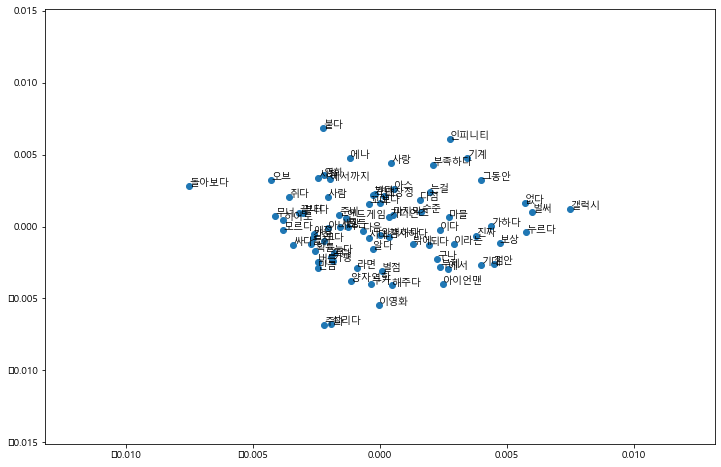

In [40]:
# 단어와 2차원 X축의 값, Y축으로 2차원 그래프를 그린다.
import matplotlib.pyplot as plt
import warnings

warnings.filterwarnings(action='ignore') 

plt.rcParams['font.family'] = 'Malgun Gothic' # 인코딩 문제

plt.figure(figsize=(12, 8))
plt.scatter(xs, ys, marker = 'o')
for i,v in enumerate(vocabs):
    plt.annotate(v, xy=(xs[i], ys[i]))